In [69]:
#importing important libraries
import numpy as np
import pandas as pd

In [259]:
class Neuralnet:
    def __init__(self,neuron_val, lr, batch_size, epochs):
        self.lr, self.batch_size, self.epochs = lr, batch_size, epochs
        self.grads_values = {}
        self.nn_architecture = [
    {"input_dim": 28*28, "output_dim": neuron_val, "activation": "relu"},
    {"input_dim": neuron_val, "output_dim": 10, "activation": "softmax"}]
        number_of_layers = len(self.nn_architecture)
        self.params_values = {}
        
        for idx, layer in enumerate(self.nn_architecture):
            layer_idx = idx + 1
            layer_input_size = layer["input_dim"]
            layer_output_size = layer["output_dim"]
            mu, sigma = 0, 0.1 # mean and standard deviation
            self.params_values['W' + str(layer_idx)] = np.random.normal(
                mu,sigma,[layer_output_size, layer_input_size]) 
            self.params_values['b' + str(layer_idx)] = np.random.normal(
                mu,sigma,[layer_output_size, 1])
 
    def params(self):
        return self.params_values

    
    def softmax(self, x):
    # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def relu(self,x):
        y = np.copy(x)
        y[y<0] = 0
        return y
    def relu_backward(self,x):
        return np.where(x < 0, 0, 1)

    def softmax_backward(self, x):
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))


    
    def feedforward(self,X):
        self.memory = {}
        A_curr = X

        for idx, layer in enumerate(self.nn_architecture):
            layer_idx = idx + 1
            A_prev = A_curr
            

            activation = layer["activation"]
            W_curr = self.params_values["W" + str(layer_idx)]
            b_curr = self.params_values["b" + str(layer_idx)]
            
            Z_curr = np.dot(W_curr, A_prev) + b_curr
#             print('Z_curr{},layer{}'.format(Z_curr, layer))
            if activation is "relu":
                A_curr = self.relu(Z_curr)
            elif activation is "softmax":
                A_curr = self.softmax(Z_curr)

            self.memory["A" + str(idx)] = A_prev
            self.memory["Z" + str(layer_idx)] = Z_curr

        return A_curr
    
    
    def backprop(self,Y_hat, Y):
        
        dA_prev = self.costderivative(Y,Y_hat)

        for layer_idx_prev, layer in reversed(list(enumerate(self.nn_architecture))):
            layer_idx_curr = layer_idx_prev + 1
            activ_function_curr = layer["activation"]

            dA_curr = dA_prev

            A_prev = self.memory["A" + str(layer_idx_prev)]
            Z_curr = self.memory["Z" + str(layer_idx_curr)]
            W_curr = self.params_values["W" + str(layer_idx_curr)]
            b_curr = self.params_values["b" + str(layer_idx_curr)]
            
            m = A_prev.shape[1]
            if  activ_function_curr is "relu":
                dZ_curr = np.multiply(dA_curr, self.relu_backward(Z_curr))
            else:
                dZ_curr = np.multiply(dA_curr, self.softmax_backward(Z_curr))
                        
            
            dA_prev = np.dot(W_curr.T, dZ_curr)
            dW_curr = np.dot(dZ_curr, A_prev.T) / m
            db_curr = np.sum(dZ_curr, axis=1, keepdims=True)/ m
#             print('dZ_curr{}, A_prev{},layer{}'.format(dZ_curr,A_prev,layer))
            

            self.grads_values["dW" + str(layer_idx_curr)] = dW_curr
            self.grads_values["db" + str(layer_idx_curr)] = db_curr
            

    def sgd(self,X,y):
        
        costs = []
        for epoch in range(self.epochs):
            batch = 0
            print('epoch',epoch)
            while(batch<len(y)):
                mini_X = X[batch:batch+self.batch_size].T
                mini_y = y[batch:batch+self.batch_size].T
                batch += self.batch_size
                Y_hat = self.feedforward(mini_X)
                self.update(mini_y,Y_hat)
            cost = self.get_cost_value(mini_y,Y_hat)
            costs.append(cost)
        return self.params_values,costs
    
    
    def update(self,y,Y_hat):
        self.backprop(Y_hat, y)
        for idx, layer in enumerate(self.nn_architecture):
            layer_idx = idx + 1
            self.params_values["W" + str(layer_idx)] -= self.lr * self.grads_values["dW" + str(layer_idx)]        
            self.params_values["b" + str(layer_idx)] -= self.lr * self.grads_values["db" + str(layer_idx)]
    
    def costderivative(self,y,y_hat):
        return -(y-y_hat)
    
    def get_cost_value(self, y, y_hat):
        inner = np.power((y - y_hat), 2)
        return np.sum(inner) / (2 * len(y))

    
    def evaluate(self,X,y):
        A_curr = X.T
        y_hat = self.feedforward(A_curr).T
        corrects= 0
        total = len(y)
        for i in range(total):
            res_max = y_hat[i].argmax()
            if res_max == y[i]:
                corrects += 1
            
        return (corrects/total)*100

In [37]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [247]:
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
trainy = pd.get_dummies(trainy)
trainX = np.asfarray(trainX) /255
testX = np.asfarray(testX) /255

trainy = np.asfarray(trainy)
testy = np.asfarray(testy)


trainy[trainy==0] = 0.01
trainy[trainy==1] = 0.99

trainX = trainX.reshape(60000,28*28)
testX = testX.reshape(10000, 28*28)
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))




Train: X=(60000, 784), y=(60000, 10)
Test: X=(10000, 784), y=(10000,)


In [ ]:
model = Neuralnet(15,0.1,16,10)
x, costs= model.sgd(trainX,trainy)

epoch 0


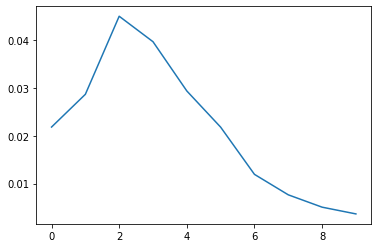

In [257]:
from matplotlib import pyplot as plt
plt.plot(costs)
plt.show()

In [258]:
model.evaluate(testX,testy)

IndexError: index 10 is out of bounds for axis 0 with size 10